# Undersample Options for Camera Flood Images

## 1. Reload images dataset

In [1]:
import pandas as pd

images_dataset_path = 'data/datasets/images.csv'
df_images = pd.read_csv(images_dataset_path)

display(df_images.columns)
display(df_images.index[:10])

Index(['id_video', 'code', 'folder', 'file_name', 'file_path', 'frame_index',
       'timestamp', 'initial_timestamp', 'seen', 'tags'],
      dtype='object')

RangeIndex(start=0, stop=10, step=1)

## 2. Preprocess the dataset

In [2]:
from modules.octa_video_util import _assign_tag
from modules.octa_video_util import filter_by_query

#### Create categorical field from tag priority list

In [3]:
# Create unique tag column based on class priority list
default_tag = 'normal'
tags_priority_list = ['alagamento', 'bolsão', 'lâmina', 'poça', 'transbordo']

df_images['tag'] = df_images['tags'].apply(lambda tags_list: _assign_tag(tags_list, tags_priority_list, default_tag))
display(df_images.tag.value_counts())

tag
normal        147594
poça           67391
lâmina          8759
alagamento      4335
bolsão          4235
transbordo      2237
Name: count, dtype: int64

#### Drop categories

In [4]:
df_images = df_images[df_images['tag'] != 'transbordo']

#### Binarize categorical variable

In [5]:
target_classes = ['lâmina', 'bolsão', 'alagamento']

# Binarize categorical variable from list of target classes
df_images['flood'] = df_images['tag'].isin(target_classes).astype(int)

display(df_images['flood'].value_counts())
print()
display(df_images.index[:10])

flood
0    214985
1     17329
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

#### Filter images

In [6]:
query_params = {'seen': True}

# Filter dataset of images by query
df_sample = filter_by_query(df_images, query_params).copy()

display(df_sample['flood'].value_counts())
print()
display(df_sample.index[:10])

flood
0    214985
1     17329
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

---
## 4. Shuffling

In [7]:
import numpy as np
import secrets
secrets.randbits(128)

def RNG():
    return np.random.default_rng(122807528840384100672342137672332424406)

# Example usage
# rng = RNG()
# idx = rng.choice(data.index, len(data), replace=replace, shuffle=False)

#### Sampling parameters

In [8]:
target_variable = 'flood'
multiclass_target_variable = 'tag'
groups_variable = 'code'

max_samples = 2000
replace = False
random_state = 0

#### Shuffle Samples

In [9]:
data = df_sample.copy()

data = data.sample(n=len(data), replace=replace, random_state=random_state)

display(data.index[:10])

Index([117849, 140116, 22843, 90909, 112686, 5198, 213855, 197013, 179200,
       168345],
      dtype='int64')

#### Get x and y (features and target variable)

In [10]:
# Get x and y
X = data.drop(target_variable, axis=1)
Y = data[target_variable].copy()

Y_multi = data[multiclass_target_variable] 
groups = data[groups_variable].copy()

display(Y.value_counts())
print()
display(Y_multi.value_counts())


flood
0    214985
1     17329
Name: count, dtype: int64

tag
normal        147594
poça           67391
lâmina          8759
alagamento      4335
bolsão          4235
Name: count, dtype: int64

---
## OPTION 1: Undersampling separately for minority and majority classes

<strong>Obs: Choose one of the following three options</strong>

##### Optional · Under sampling between subclasses of the majority class only

Best result

In [101]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=replace)

x_res, y_multi_res = rus.fit_resample(X[Y==0], Y_multi[Y==0])
x_res = pd.concat([x_res, X[Y==1]])
y_multi_res = pd.concat([y_multi_res, Y_multi[Y==1]])
y_res = Y.loc[y_multi_res.index]

display(y_multi_res.value_counts())
print()
display(y_res.value_counts())
print()
display(y_res.index)

tag
normal        58101
poça          58101
lâmina         5488
alagamento     3150
bolsão         1246
Name: count, dtype: int64

flood
0    116202
1      9884
Name: count, dtype: int64

Index([166353,  37064, 129160,  98792,  93485, 108443,  92090,  82884,  78943,
       111312,
       ...
        52513,  79224,  15115, 150295, 121561,  89231,  49866,  41504,  70608,
       150550],
      dtype='int64', length=126086)

##### Optional · Under sampling between subclasses of the minority class only

In [21]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=replace)

x_res, y_multi_res = rus.fit_resample(X[Y==1], Y_multi[Y==1])
x_res = pd.concat([x_res, X[Y==0]])
y_multi_res = pd.concat([y_multi_res, Y_multi[Y==0]])
y_res = Y.loc[y_multi_res.index]

display(y_multi_res.value_counts())
print()
display(y_res.value_counts())
print()
display(y_res.index)

tag
normal        100783
poça           58101
alagamento      1246
bolsão          1246
lâmina          1246
Name: count, dtype: int64

flood
0    158884
1      3738
Name: count, dtype: int64

Index([  3575,  49055,  70597,  29505, 150562,  39867,  12182,  72705,  47044,
       150337,
       ...
        48600, 112555,  86293, 122714,  41993,  97729,  96029, 152810, 118087,
        43567],
      dtype='int64', length=162622)

##### Optional · Under sampling between subclasses of the minority/majority classes separately

In [44]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=replace)

x_res, y_multi_res = rus.fit_resample(X[Y==1], Y_multi[Y==1])
x_res_majority, y_res_majority = rus.fit_resample(X[Y==0], Y_multi[Y==0])
x_res = pd.concat([x_res, x_res_majority])
y_multi_res = pd.concat([y_multi_res, y_res_majority])
y_res = Y.loc[y_multi_res.index]

display(y_multi_res.value_counts())
print()
display(y_res.value_counts())
print()
display(y_res.index)

tag
normal        58101
poça          58101
alagamento     1246
bolsão         1246
lâmina         1246
Name: count, dtype: int64

flood
0    116202
1      3738
Name: count, dtype: int64

Index([  3575,  49055,  70597,  29505, 150562,  39867,  12182,  72705,  47044,
       150337,
       ...
       108639, 133793,  73135, 133168, 138218, 108766,  52620, 112555, 122714,
        41993],
      dtype='int64', length=119940)

---
## OPTION 2: Undersampling binary classes

In [102]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=replace)

x_res, y_res = rus.fit_resample(x_res, y_res)

groups_res = groups.loc[y_res.index].copy()
y_multi_res = Y_multi.loc[y_res.index].copy()

print('Total samples:', len(y_res))
print()
display(y_res.value_counts())
print()
print(y_multi_res.value_counts())
print()
display(y_res.index)

Total samples: 19768



flood
0    9884
1    9884
Name: count, dtype: int64


tag
lâmina        5488
poça          4956
normal        4928
alagamento    3150
bolsão        1246
Name: count, dtype: int64



Index([132442,  73812,  95280,  35296,  73243, 143576, 126209, 148940,  54517,
       113061,
       ...
        52513,  79224,  15115, 150295, 121561,  89231,  49866,  41504,  70608,
       150550],
      dtype='int64', length=19768)

#### Optional · Sampling based on `max_samples`

In [103]:
y_res = pd.concat([
    y_res[y_res == 0].sample(int(max_samples / 2), replace=replace, random_state=random_state),
    y_res[y_res == 1].sample(int(max_samples / 2), replace=replace, random_state=random_state)
], axis=0)

x_res = X.loc[y_res.index].copy()
groups_res = groups.loc[y_res.index].copy()

display(y_res.value_counts())
print()
display(y_res.index)

flood
0    1000
1    1000
Name: count, dtype: int64

Index([151149,  55823,  14423,  70564,  92916, 166171, 111526, 101842, 107063,
       119478,
       ...
       159845, 113351,  50924, 117329,  43412,  21266,  98026, 104296,  29494,
       145661],
      dtype='int64', length=2000)

---
### OPTION 3: Even Group Undersample

In [47]:
import numpy as np

def group_even_undersample(x, y, groups, prct=0.5, n=None, random_state=None):
    group_cnt = groups.value_counts()
    if n is None:
        n = int(np.percentile(group_cnt, prct * 100))
    index = []
    for group in group_cnt.index:
        index += y[groups == group].sample(min(n, group_cnt[group]), replace=False, random_state=random_state).index.tolist()
    return x.loc[index], y.loc[index]

#### Undersample single class evenly · keeping all positive samples

In [15]:
subsample_index = []

class_df = df_sample[df_sample['tag'] == 'poça']
x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']

x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=54, random_state=random_state)
subsample_index += y_cls_res.index.tolist()

class_df = df_sample[df_sample['tag'] == 'normal']
x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']

x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=37, random_state=random_state)
subsample_index += y_cls_res.index.tolist()

majority_samples = df_sample.loc[subsample_index]
sample_even = pd.concat([majority_samples, df_sample[df_sample['flood'] == 1.0]])

display(sample_even['flood'].value_counts())
print()
display(sample_even['tag'].value_counts())
print()
display(sample_even.index)

flood
0    10006
1     9884
Name: count, dtype: int64

tag
lâmina        5488
normal        5035
poça          4971
alagamento    3150
bolsão        1246
Name: count, dtype: int64

Index([102541,  88264,  82975,  95097,  75101, 102549, 140199,  69780,  75044,
        85658,
       ...
       166947, 166948, 166949, 166950, 166951, 166952, 166953, 166954, 166955,
       166956],
      dtype='int64', length=19890)

#### One more time · Account for `max_samples`

In [16]:
subsample_index = []

class_df = sample_even[sample_even['flood'] == 0.0]
x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']

x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=6, random_state=random_state)
subsample_index += y_cls_res.index.tolist()

class_df = sample_even[sample_even['flood'] == 1.0]
x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']

x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=34, random_state=random_state)
subsample_index += y_cls_res.index.tolist()

subsample_even = sample_even.loc[subsample_index]

print()
display(subsample_even['flood'].value_counts())
print()
display(subsample_even['tag'].value_counts())
print()
display(subsample_even.index)

flood
1    1083
0    1080
Name: count, dtype: int64

tag
normal        574
lâmina        550
poça          506
alagamento    297
bolsão        236
Name: count, dtype: int64

Index([ 82975, 146294, 131062,  82936,  64347, 130879, 160753, 166698, 163073,
       156635,
       ...
       159950, 159961, 159957, 159949, 159955, 159958, 159951, 159948, 159953,
       159960],
      dtype='int64', length=2163)

#### Final distribution of samples per camera

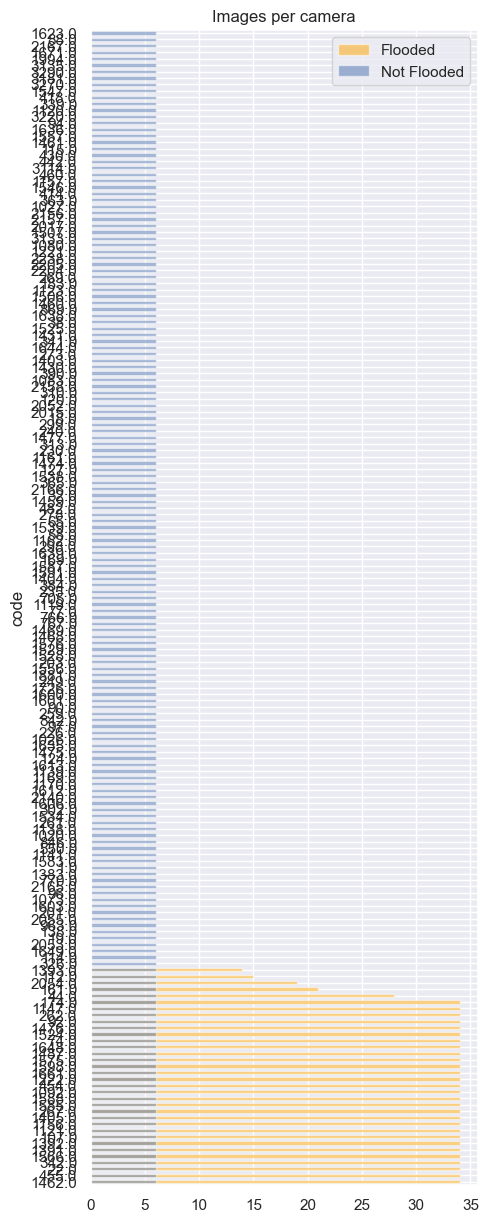

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

fig = plt.figure(figsize=(5, 15))
ax = subsample_even[subsample_even['flood'] == 1.0]['code'].value_counts().plot.barh(label='Flooded', color='orange', alpha=0.5)
subsample_even[subsample_even['flood'] == 0.0]['code'].value_counts().plot.barh(label='Not Flooded', alpha=0.5, ax=ax)

# majority = subsample_even[subsample_even['flood'] == 0.0]
# majority[majority['tag'] == 'poça']['code'].value_counts().plot.barh(label='Not Flooded (Pud)', color='green', alpha=0.5, ax=ax)
# majority[majority['tag'] == 'normal']['code'].value_counts().plot.barh(label='Not Flooded (Normal)', alpha=0.5, ax=ax)

plt.title('Images per camera')
plt.legend()
plt.show()

#### Final undersample variables

In [20]:
x_res = subsample_even.drop('flood', axis=1)
y_res = subsample_even['flood'].copy()
groups_res = subsample_even['code'].copy()

---
### OPTION 4: Balanced sampling per camera

In [47]:
import numpy as np

def group_even_undersample(x, y, groups, prct=0.5, n=None, random_state=None):
    group_cnt = groups.value_counts()
    if n is None:
        n = int(np.percentile(group_cnt, prct * 100))
    index = []
    for group in group_cnt.index:
        index += y[groups == group].sample(min(n, group_cnt[group]), replace=False, random_state=random_state).index.tolist()
    return x.loc[index], y.loc[index]

#### Undersample per camera

In [32]:
cnt_0 = groups[Y == 0.0].value_counts()
cnt_1 = groups[Y == 1.0].value_counts()

index = []
for code in cnt_1.index:
    Y_code = Y[groups == code]
    n_samples = min(cnt_0.loc[code], cnt_1.loc[code])
    index += Y_code[Y_code == 1.0].index.tolist()
    index += Y_code[Y_code == 0.0].sample(n_samples, replace=replace, random_state=random_state).index.tolist()

x_res = X.loc[index]
y_res = Y.loc[index]
y_multi_res = Y_multi.loc[index]
groups_res = groups.loc[index]

print('Total samples:', len(y_res))
print()
display(y_res.value_counts())
print()
print(y_multi_res.value_counts())
print()
display(y_res.index)

Total samples: 33681



flood
1    17329
0    16352
Name: count, dtype: int64


tag
normal        10803
lâmina         8759
poça           5549
alagamento     4335
bolsão         4235
Name: count, dtype: int64



Index([170628, 214759,  95782, 214947, 170520, 209463, 159342, 177932, 177869,
       157941,
       ...
       197704, 182534, 188888, 188969, 197638, 197659, 197565, 204224, 182592,
       182600],
      dtype='int64', length=33681)

#### Class count per camera (excluding cameras without positive samples)

code,278.0,235.0,1538.0,3181.0,326.0,1393.0,442.0,298.0,430.0,92.0,...,1606.0,3133.0,1430.0,1881.0,1119.0,1431.0,3114.0,268.0,313.0,1475.0
class 0,3238,2266,1935,1800,1112,690,157,630,630,516,...,109,90,90,45,40,28,21,19,15,14
class 1,3238,2266,1935,1800,1112,849,675,630,630,516,...,109,90,90,45,40,28,21,19,15,14


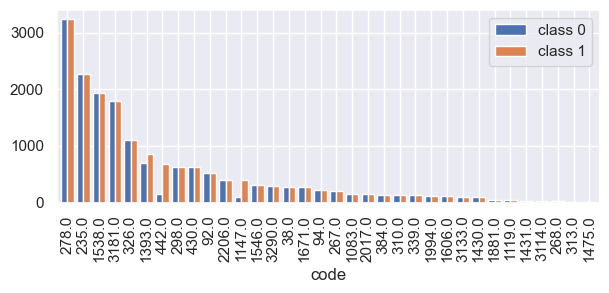

In [66]:
cnt_0 = groups_res[y_res == 0.0].value_counts()
cnt_1 = groups_res[y_res == 1.0].value_counts()
cnt_0 = cnt_0.loc[cnt_1.index]

code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
display(code_class_cnt.T)

fig = plt.figure(figsize=(7, 2.5))
ax = fig.subplots(1, 1)

code_class_cnt.plot.bar(width=0.8, ax=ax)
plt.show()

#### Even groups sampling

In [55]:
msk_0 = y_res == 0.0
msk_1 = y_res == 1.0

x_even_0, y_even_0 = group_even_undersample(x_res[msk_0], y_res[msk_0], groups_res[msk_0], n=100, random_state=random_state)
x_even_1, y_even_1 = group_even_undersample(x_res[msk_1], y_res[msk_1], groups_res[msk_1], n=100, random_state=random_state)

y_even = pd.concat([y_even_0, y_even_1])
x_even = X.loc[y_even.index]
groups_even = groups.loc[y_even.index]
y_multi_even = Y_multi.loc[y_even.index]

print('Total samples:', len(y_even))
print()
display(y_even.value_counts())
print()
print(y_multi_even.value_counts())
print()
display(y_even.index)

Total samples: 5724



flood
0    2862
1    2862
Name: count, dtype: int64


tag
normal        1687
lâmina        1326
poça          1175
alagamento     883
bolsão         653
Name: count, dtype: int64



Index([163557, 160725, 163347, 178427, 161525, 178743, 178469, 159483, 158247,
        92150,
       ...
       188826, 188831, 188828, 188827, 188832, 188833, 188829, 188834, 188825,
       188824],
      dtype='int64', length=5724)

#### Class count per camera (excluding cameras without positive samples)

code,278.0,3290.0,1606.0,1994.0,339.0,310.0,384.0,2017.0,1083.0,235.0,...,2206.0,3133.0,1430.0,1881.0,1119.0,1431.0,3114.0,268.0,313.0,1475.0
class 0,100,100,100,100,100,100,100,100,100,100,...,100,90,90,45,40,28,21,19,15,14
class 1,100,100,100,100,100,100,100,100,100,100,...,100,90,90,45,40,28,21,19,15,14


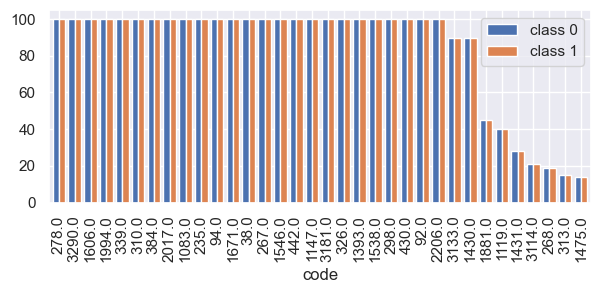

In [65]:
cnt_0 = groups_even[y_even == 0.0].value_counts()
cnt_1 = groups_even[y_even == 1.0].value_counts()
cnt_0 = cnt_0.loc[cnt_1.index]

code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
display(code_class_cnt.T)

fig = plt.figure(figsize=(7, 2.5))
ax = fig.subplots(1, 1)

code_class_cnt.plot.bar(width=0.8, ax=ax)
# plt.legend(loc='lower left')
# plt.tight_layout()
plt.show()

#### Get `x_res` `y_res` and `groups_res`

In [67]:
x_res = X.loc[y_even.index].copy()
y_res = Y.loc[y_even.index].copy()
groups_res = groups.loc[y_even.index].copy()